In [21]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q -nc https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q -nc https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q -nc https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q -nc https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q -nc https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!rm -r ./content/
!mkdir ./content/
!unzip -q -o ./training1.zip    -d ./content
!unzip -q -o ./training2.zip    -d ./content
!unzip -q -o ./test.zip         -d ./content
!unzip -q -o ./test_partial.zip -d ./content

# Combine the two traning directories
!echo "Merging training data..."
!mkdir ./content/training
!mv -f ./content/training1/* ./content/training/
!mv -f ./content/training2/* ./content/training/

# Cleanup
!echo "Cleaning up..."
!rmdir ./content/training1
!rmdir ./content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

%pip install 

!echo "Data ready."

"Downloading files..."


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


"Unzipping files..."


'rm' is not recognized as an internal or external command,
operable program or batch file.
The syntax of the command is incorrect.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


"Merging training data..."


The syntax of the command is incorrect.
'mv' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.


"Cleaning up..."


Invalid switch - "content".
Invalid switch - "content".
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


ERROR: You must give at least one requirement to install (see "pip help install")

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


"Data ready."


In [6]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
from skimage import exposure
from sklearn.metrics import recall_score, precision_score, f1_score, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
import numpy as np

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'


In [4]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation. 


training_dir = './content/training/'
image_size = (100, 100)
def stretch(image) :
        low, high = np.percentile(image, (2,98))
        return exposure.rescale_intensity(image, in_range=(low, high))

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        rotation_range=3,
        width_shift_range=0.15,
        height_shift_range=0.15,
        brightness_range=[.93,1.2],
        shear_range=3,
        zoom_range=.075,
        fill_mode='reflect',
        # preprocessing_function= stretch
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        # preprocessing_function= stretch
        )
stretch_validation_datagen = ImageDataGenerator(
        # rescale=1./255,
        validation_split=.2,
        preprocessing_function= stretch
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,
        shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42,
        shuffle=False)
stretch_validation_generator = stretch_validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42,
        shuffle=False)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


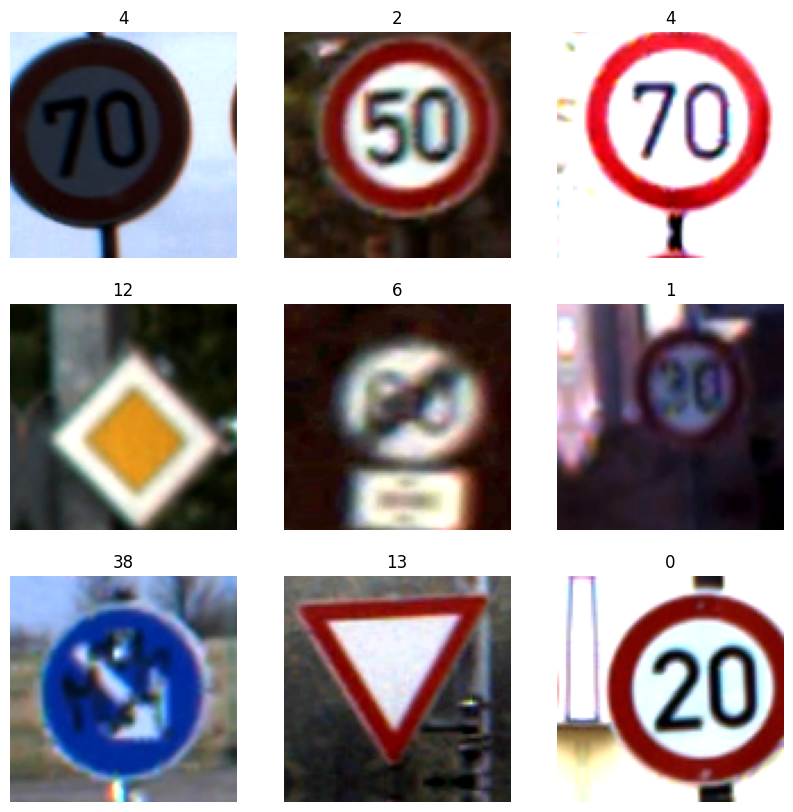

In [34]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]      
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break



In [35]:
# Build a model...
def create_model(initializer='uniform', activation='selu', optimizer='adam', dropoutRate = 0.1):
    model = InceptionV3()
    opt = tf.keras.optimizers.Adam(epsilon=0.1)
    model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])    
    return model

model = create_model()
checkpoint = keras.callbacks.ModelCheckpoint("./checkpoint",monitor='val_loss', save_best_only=True, mode='min', verbose=True)


In [43]:
checkpoint = keras.callbacks.ModelCheckpoint("./checkpoint",monitor='val_loss', save_best_only=True, mode='min', verbose=True)
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
history = model.fit(
    train_generator,
    steps_per_epoch=300,
    epochs=1000, 
    validation_data=validation_generator,
    # validation_steps=200,
    callbacks=[early_stop, checkpoint])

try:
    hist.drop(columns='index', inplace=True)
    hist = pd.concat([hist, pd.DataFrame(history.history)], axis = 0, ignore_index=True)
except NameError:
    hist = pd.DataFrame(history.history)

hist = hist.reset_index()

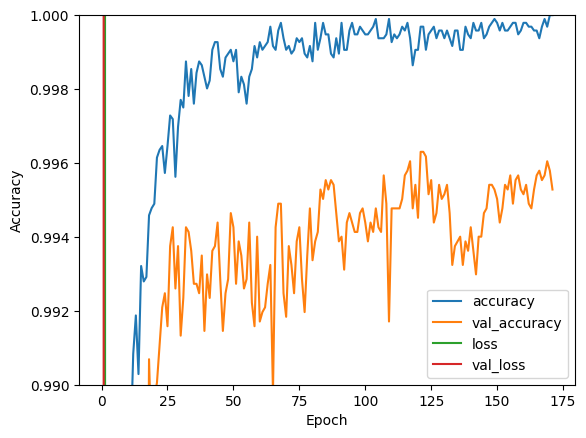

In [45]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.99, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

246/246 [==============================] - 18s 68ms/step
4.    recall:0.9960464226501722 precision:0.9960886743359558 f1:0.9960333244051751 accuracy:0.9960464226501722
4


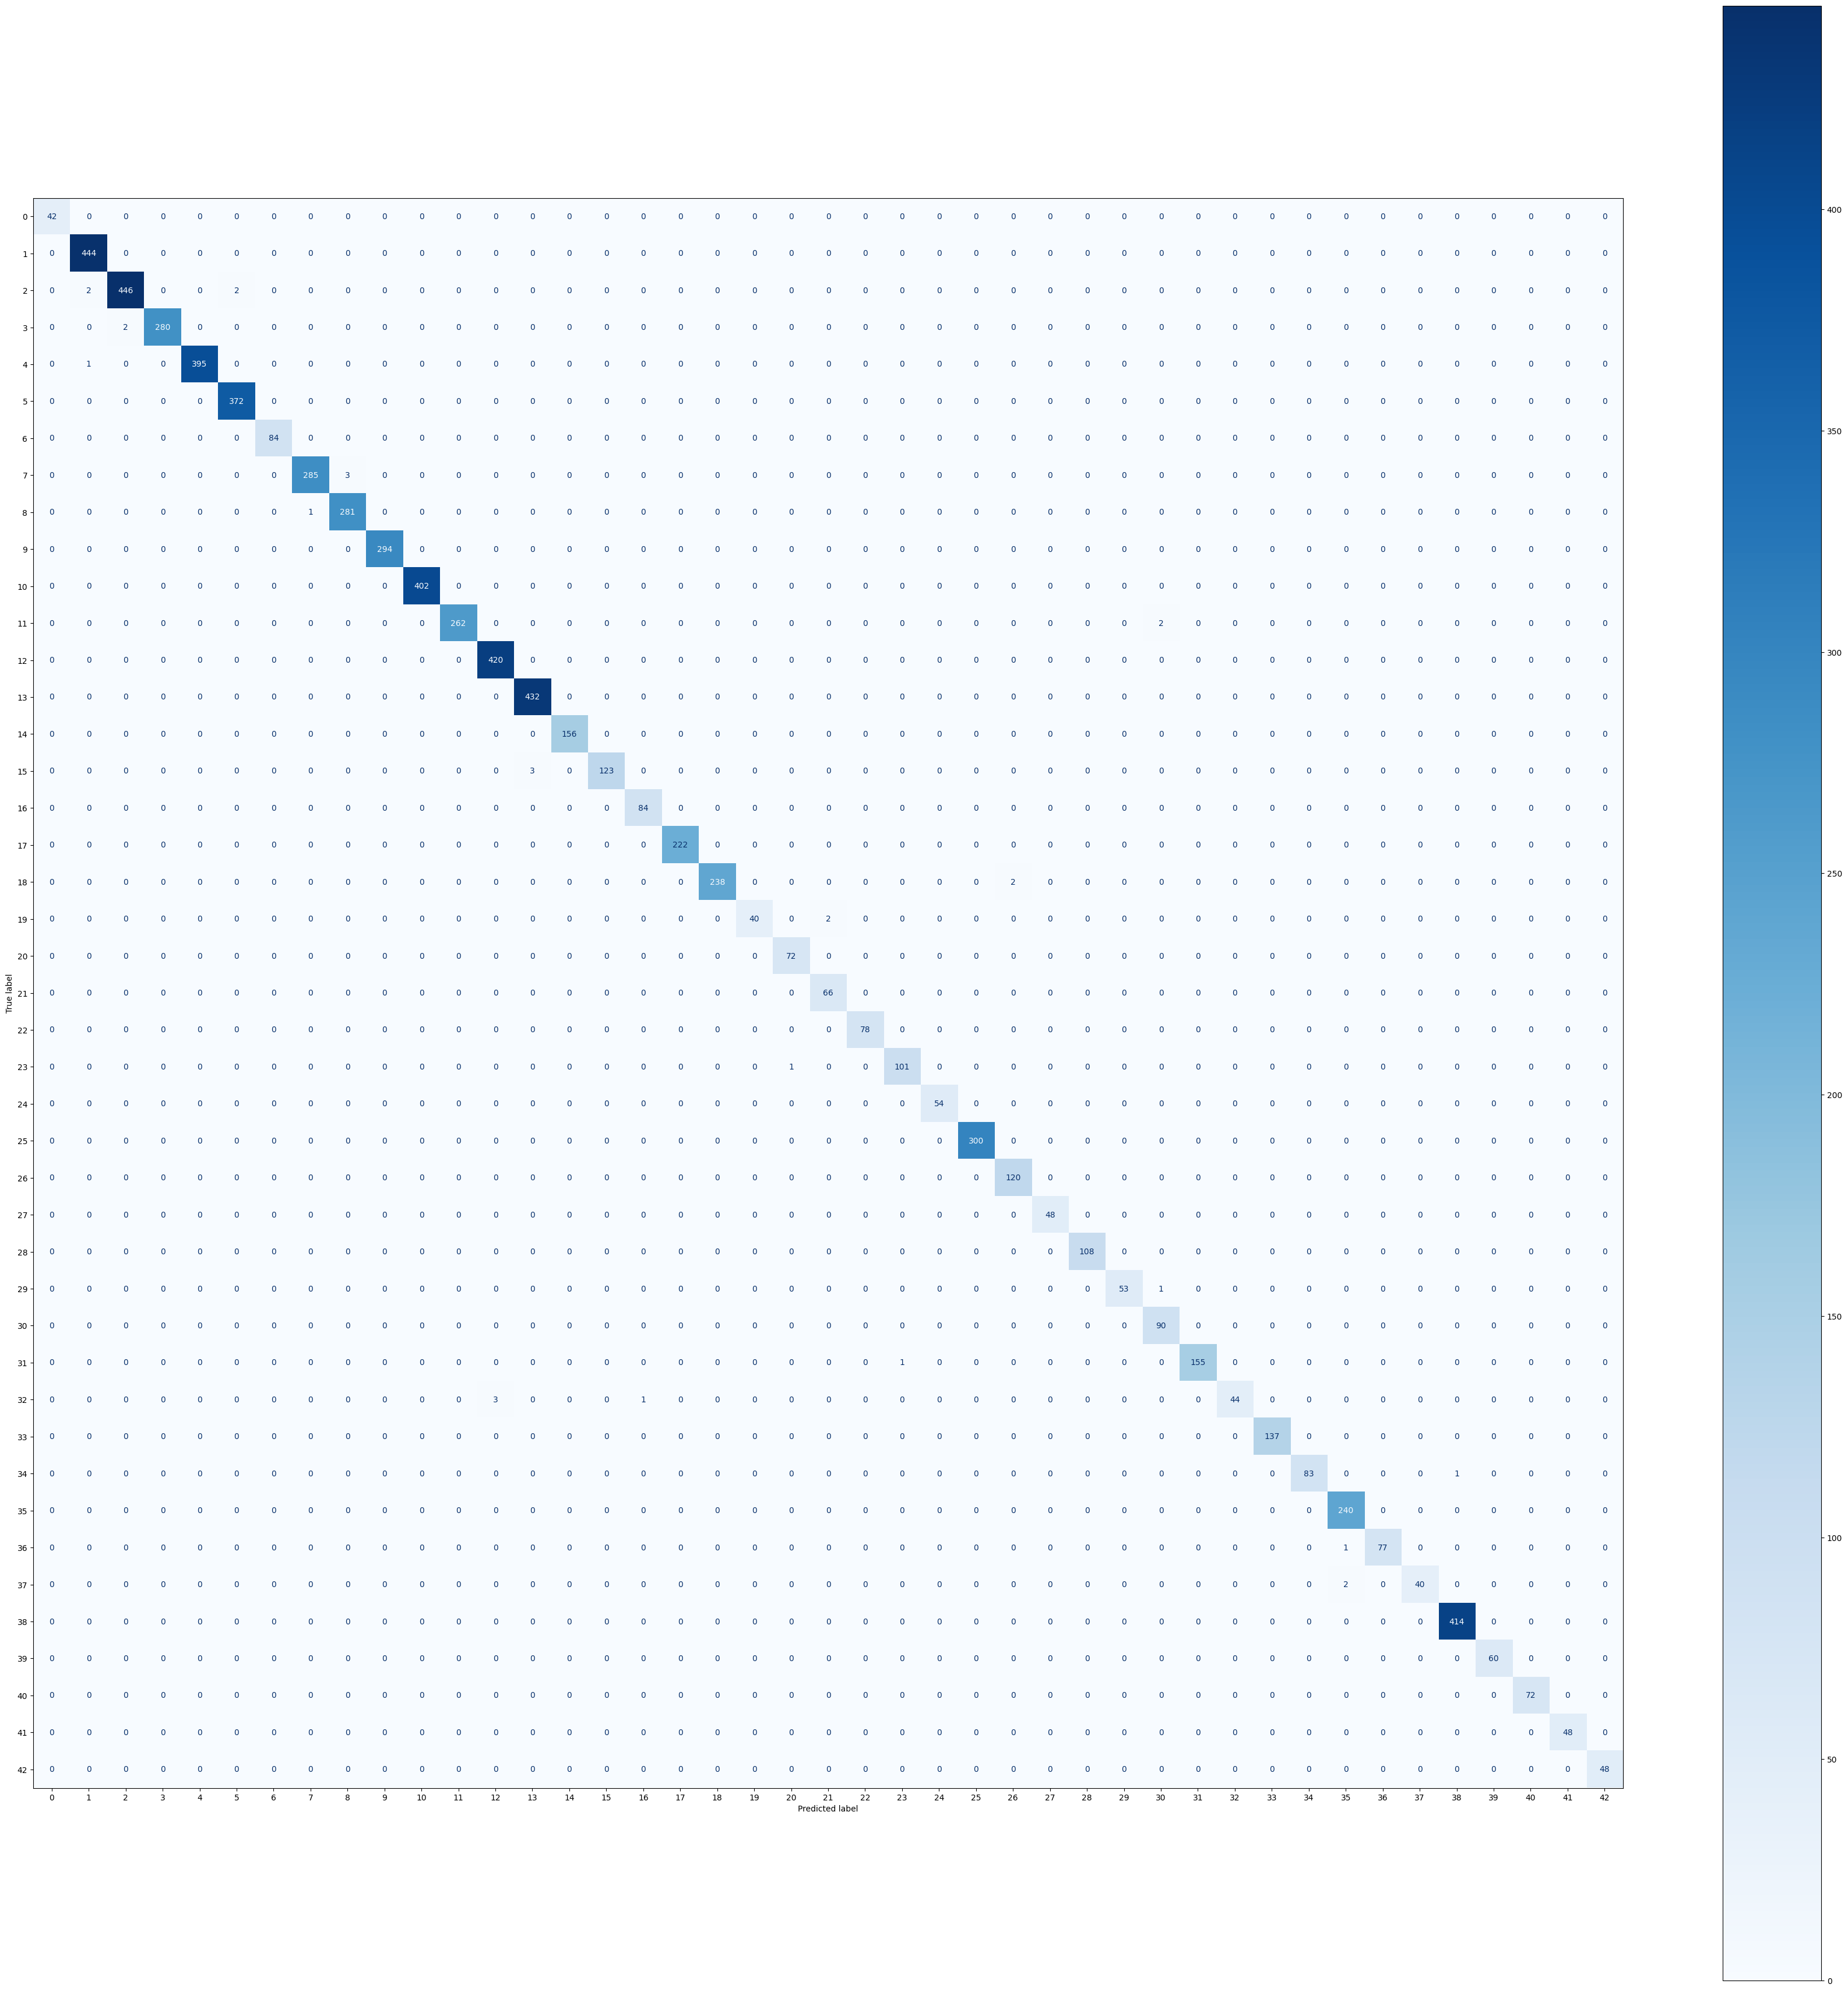

In [10]:

# for checkpoint in ['checkpoint', 'checkpoint2', 'checkpoint3', 'checkpoint4']:
# for pair in [[validation_generator, 4], [stretch_validation_generator, 6]]:
for pair in [[validation_generator, 4]]:
    # for checkpointNum in 5:
    loopGenerator = pair[0]
    checkpointNum = pair[1]
    model = keras.models.load_model('checkpoint' + str(checkpointNum))
    labels = loopGenerator.labels
    loopGenerator.reset()
    probabilities = model.predict(loopGenerator)
    predictions = np.array([np.argmax(probabs) for probabs in probabilities])
    recall = recall_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    accuracy = accuracy_score(loopGenerator.labels, predictions)
    print (str(checkpointNum) + ".    recall:" + str(recall) + " precision:" + str(precision)+ " f1:" + str(f1)+ " accuracy:" + str(accuracy))
    print (str(checkpointNum))
    cmd = ConfusionMatrixDisplay(confusion_matrix(labels,predictions))
    fig, ax = plt.subplots(figsize = (44,44))
    cmd.plot(ax=ax,cmap='Blues', values_format='.5g')
    # plt.show()

## Testing the model
Once you have built and trained your model, the next step is to run the test images through it and see how well your model does at making predictions for images it has never seen before. 

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.



```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = './content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



In [11]:
test_dir = './content/'
        

test_datagen = ImageDataGenerator(rescale=1./255)
stretch_test_datagen = ImageDataGenerator(preprocessing_function=stretch)
y_partial = pd.read_csv('./content/test_classes_partial.csv')


# for pair in [[test_datagen, 4],[test_datagen, 11], [stretch_test_datagen, 11]]:
for pair in [[test_datagen, 0]]:
        loopGenerator = pair[0].flow_from_directory(
                test_dir,
                classes=['test_partial'],
                target_size=image_size,
                class_mode='sparse',
                shuffle=False)
        # checkpointNum = pair[1]
        # model = keras.models.load_model('checkpoint' + str(checkpointNum))
        model = keras.models.load_model('final_model')
        labels = y_partial["ClassId"]
        loopGenerator.reset()
        probabilities = model.predict(loopGenerator)
        predictions = np.array([np.argmax(probabs) for probabs in probabilities])
        recall = recall_score(labels, predictions, average="weighted")
        precision = precision_score(labels, predictions, average="weighted")
        f1 = f1_score(labels, predictions, average="weighted")
        accuracy = accuracy_score(labels, predictions)
        print ("Final Model" + ".    recall:" + str(recall) + " precision:" + str(precision)+ " f1:" + str(f1)+ " accuracy:" + str(accuracy))
        # print (str(checkpointNum) + ".    recall:" + str(recall) + " precision:" + str(precision)+ " f1:" + str(f1)+ " accuracy:" + str(accuracy))
        # print (str(checkpointNum))
        # cmd = ConfusionMatrixDisplay(confusion_matrix(labels,predictions))
        # fig, ax = plt.subplots(figsize = (44,44))
        # cmd.plot(ax=ax,cmap='Blues', values_format='.5g')
        # plt.show()

Found 201 images belonging to 1 classes.
7/7 [==============================] - 2s 92ms/step
Final Model.    recall:0.9900497512437811 precision:0.9925373134328358 f1:0.9904551317486642 accuracy:0.9900497512437811


##Partial Hold out Dataset
You're given the answers to the first 200 images in the hold out dataset. 

Once you have predictions for the partial holdout dataset, you'll need to compare those predictions against the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does. 

Make sure to use the insights gained from the partial hold out dataset in your executive summary.

Once you feel confident, you will need to predict for the full test dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = './content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```

In [12]:
test_dir = './content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)

model = keras.models.load_model('./final_model/')
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]    
pd.DataFrame(predictions).to_csv('team8-module2-predictions', index=False, header= ["predictions"])


Found 12630 images belonging to 1 classes.
395/395 [==============================] - 36s 89ms/step
